In [1]:
!unzip jena_climate.zip

Archive:  jena_climate.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
# !mkdir jena_climate
# !cd jena_climate
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [3]:
import os

data_dir = '/content'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')


f = open(fname)
data = f.read()
f.close()


lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
# Parsing the data
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

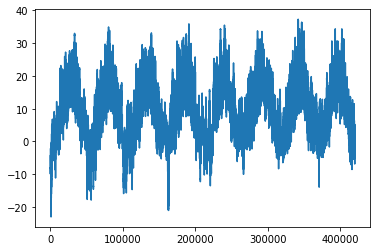

In [5]:
# Plotting the Temperature time-series
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

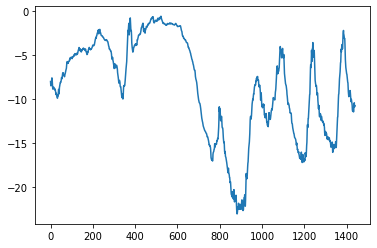

In [6]:
# Plotting the first 10-days of Temperature time-series

plt.plot(range(1440), temp[:1440])

In [7]:
# Normalizing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
# Generator yielding timeseries samples and targets

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [9]:
# Preparing the training, validation, and test generator

lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

In [11]:
# Preparing the training, validation, and test generator

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
                    
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [12]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()     

0.28969941979609765


In [13]:
# Converting the MAE back to Celsius error
celsius_mae = 0.29 * std[1]

In [15]:
# Training and evaluating a densely connected model
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator( train_gen,
                              steps_per_epoch=500,
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 991s 2s/step - loss: 1.2414 - val_loss: 0.5657
Epoch 2/20
500/500 [==============================] - 990s 2s/step - loss: 0.4051 - val_loss: 0.3376
Epoch 3/20
500/500 [==============================] - 1050s 2s/step - loss: 0.2889 - val_loss: 0.3396
Epoch 4/20
500/500 [==============================] - 990s 2s/step - loss: 0.2643 - val_loss: 0.3358
Epoch 5/20
500/500 [==============================] - 990s 2s/step - loss: 0.2545 - val_loss: 0.3162
Epoch 6/20
500/500 [==============================] - 978s 2s/step - loss: 0.2447 - val_loss: 0.3104
Epoch 7/20
500/500 [==============================] - 990s 2s/step - loss: 0.2365 - val_loss: 0.3416
Epoch 8/20
500/500 [==============================] - 983s 2s/step - loss: 0.2290 - val_loss: 0.3495
Epoch 9/20
500/500 [==============================] - 990s 2s/step - loss: 0.2245 - val_loss: 0.3413
Epoch 10/20
500/500 [==============================] - 1050s 2s/step - loss: 0.2214 - val_

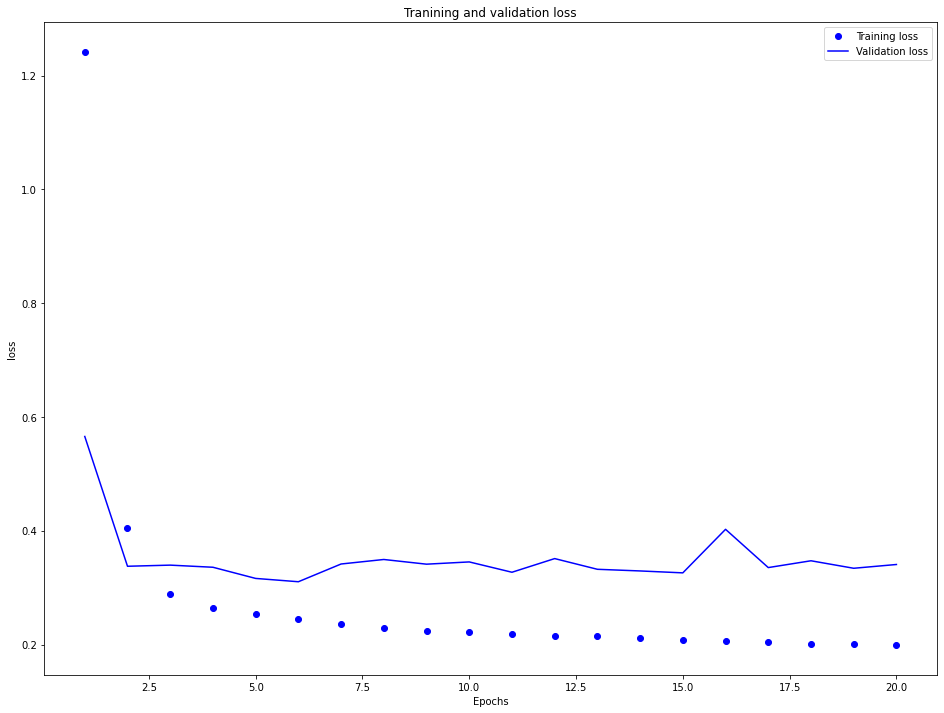

In [16]:
# Plotting results

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1) 

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()